In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

Fitting 10 folds for each of 20 candidates, totalling 200 fits


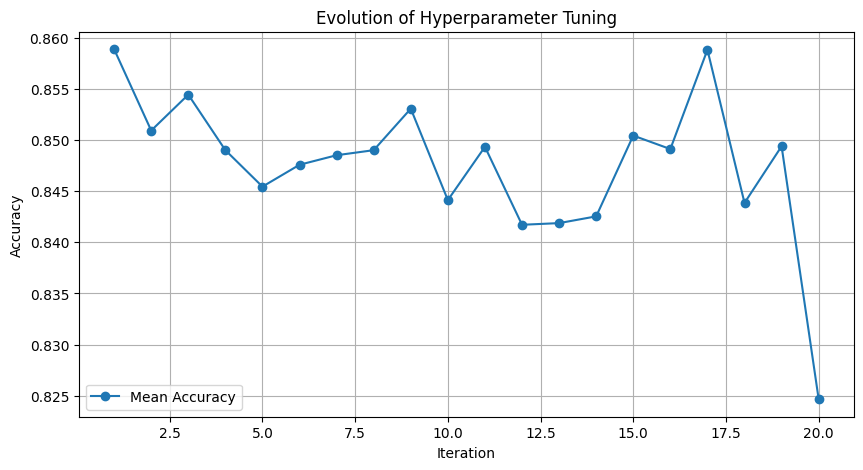

---------------------------------------------


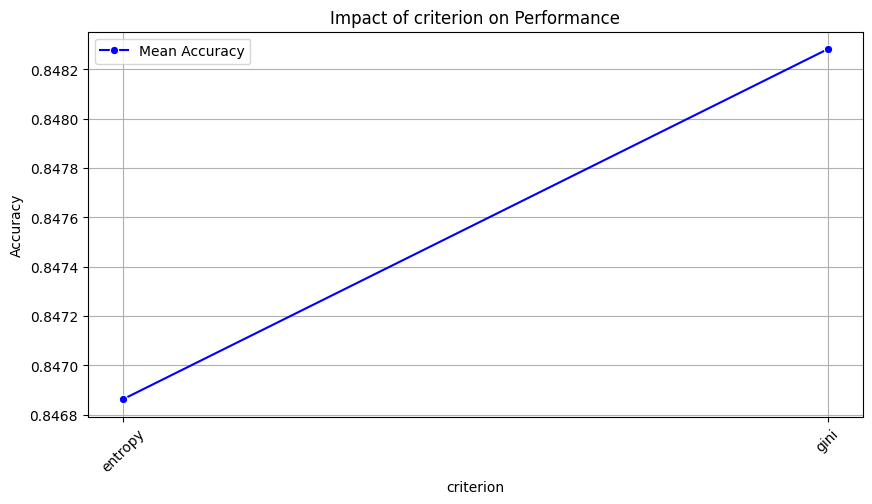

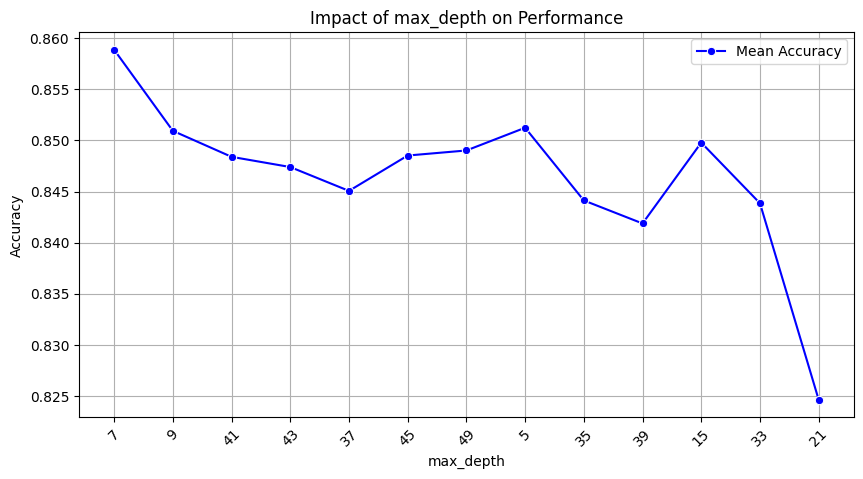

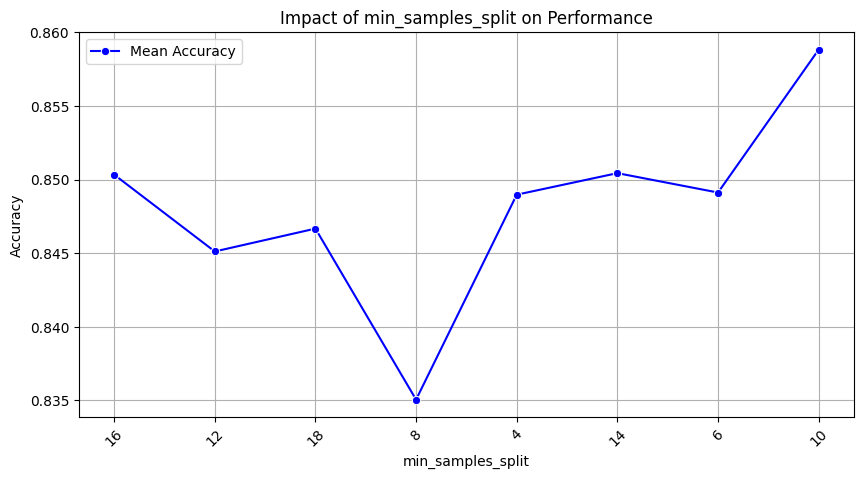

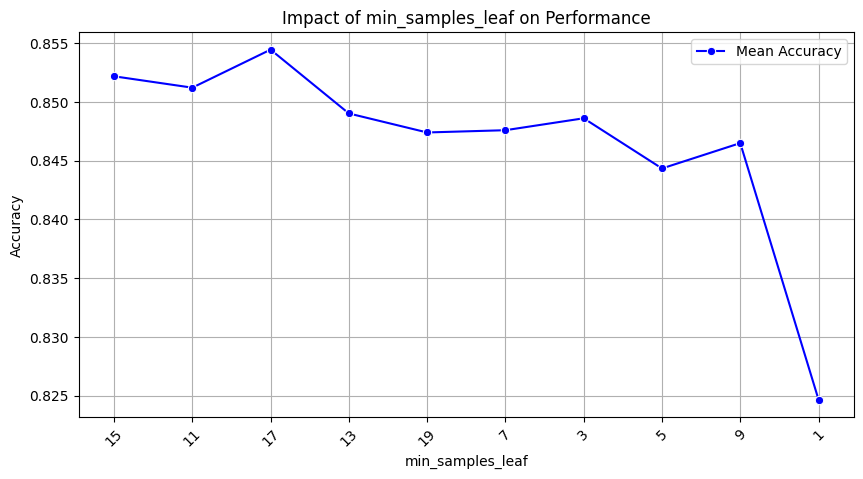

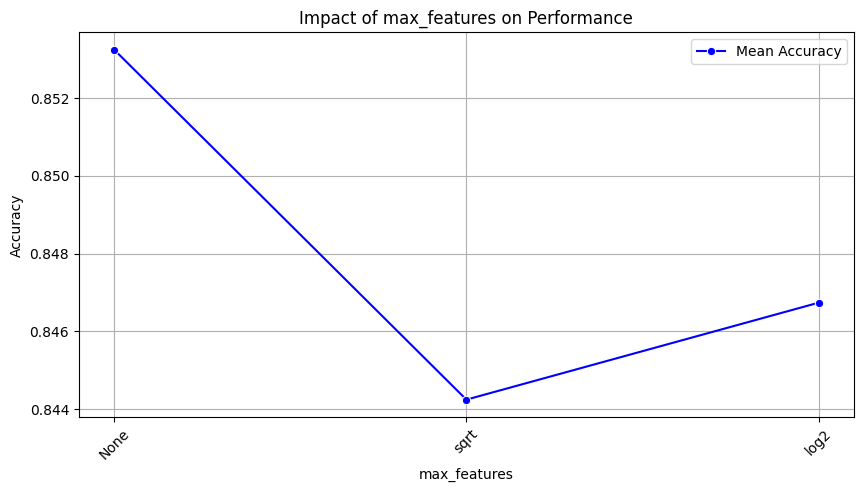


Melhores hiperparâmetros encontrados:
min_samples_split: 16
min_samples_leaf: 15
max_features: None
max_depth: 7
criterion: entropy

Desempenho no conjunto de teste:
Acurácia: 0.8571
Precisão: 0.8917
Recall: 0.9070
F1-score: 0.8992
AUC-ROC: 0.9117


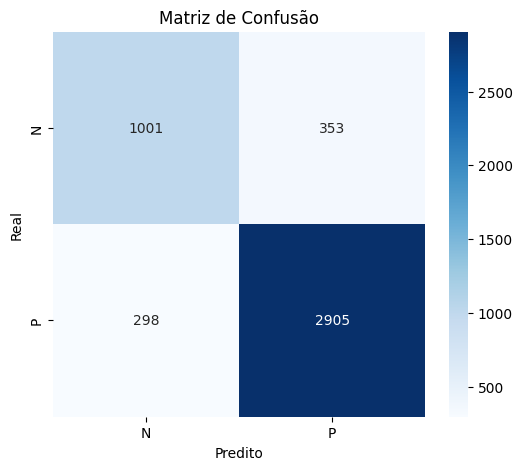


Relatório de Classificação:
              precision    recall  f1-score   support

           N       0.77      0.74      0.75      1354
           P       0.89      0.91      0.90      3203

    accuracy                           0.86      4557
   macro avg       0.83      0.82      0.83      4557
weighted avg       0.86      0.86      0.86      4557



In [ ]:
# Carregar dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separar features e target
X_train = train_df.drop(columns=['binaryClass'])
y_train = train_df['binaryClass']
X_test = test_df.drop(columns=['binaryClass'])
y_test = test_df['binaryClass']

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definir espaço de hiperparâmetros
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 50, 2),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': ['sqrt', 'log2', None]
}

# Executar RandomizedSearchCV
dt = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(dt, param_dist, n_iter=20, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

def plot_search_results(results):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 21), results['mean_test_score'], marker='o', linestyle='-', label='Mean Accuracy', alpha=1.0)
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Evolution of Hyperparameter Tuning")
    plt.legend()
    plt.grid()
    plt.show()
    print('---------------------------------------------')

results_df = pd.DataFrame(random_search.cv_results_)
plot_search_results(results_df)

# Plotar evolução dos hiperparâmetros
def plot_hyperparameter_evolution(results, param_name):
    param_values = [str(param) for param in results['param_' + param_name]]
    mean_scores = results['mean_test_score']

    df = pd.DataFrame({
        'param_value': param_values,
        'mean_score': mean_scores
    })

    plt.figure(figsize=(10, 5))
    sns.lineplot(x='param_value', y='mean_score', data=df, marker='o', label='Mean Accuracy', color='b', errorbar=None)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Impact of {param_name} on Performance")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

for param in ['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']:
    if 'param_' + param in results_df.columns:
        plot_hyperparameter_evolution(results_df, param)

# Obter os melhores hiperparâmetros
best_params = random_search.best_params_
print("\nMelhores hiperparâmetros encontrados:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Criar e treinar o modelo com os melhores hiperparâmetros
best_tree = random_search.best_estimator_

# Avaliação no conjunto de teste
y_pred = best_tree.predict(X_test)
y_prob = best_tree.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P')
roc_auc = roc_auc_score(y_test.map({'N': 0, 'P': 1}), y_prob)

print("\nDesempenho no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['N', 'P'], yticklabels=['N', 'P'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


<ipython-input-9-58b7e1b0354f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='viridis')


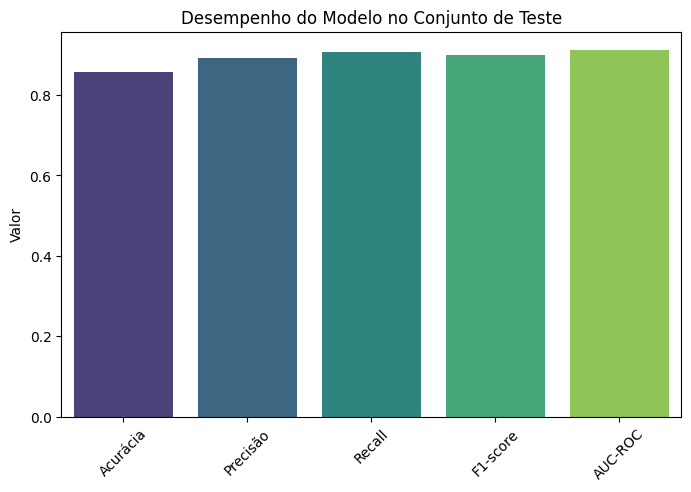

F1-score no Treino: 0.9156
F1-score no Teste: 0.8992
O modelo apresenta um equilíbrio entre treino e teste.


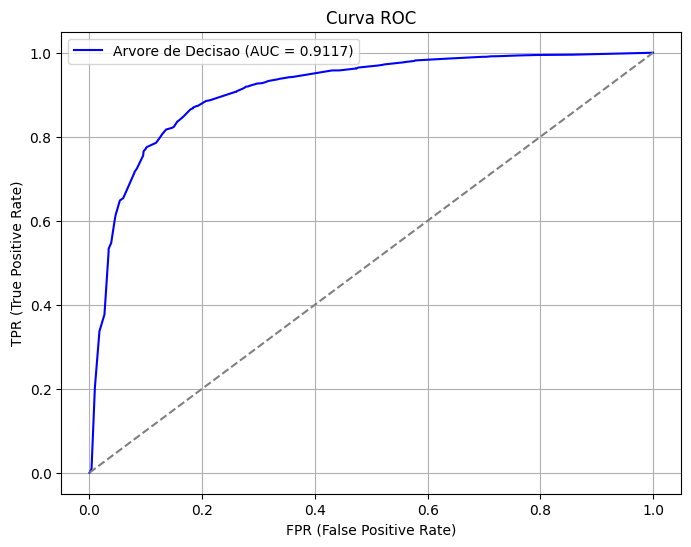


Conclusões:
O modelo de Árvore de Decisão foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:
{'min_samples_split': np.int64(16), 'min_samples_leaf': np.int64(15), 'max_features': None, 'max_depth': np.int64(7), 'criterion': 'entropy'}
Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.


In [ ]:
# 1. Comparacao de Desempenho
metrics = [accuracy, precision, recall, f1, roc_auc]
labels = ["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title("Desempenho do Modelo no Conjunto de Teste")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# 2. Overfitting vs. Underfitting
train_pred = best_tree.predict(X_train)
train_f1 = f1_score(y_train, train_pred, pos_label='P')
print(f"F1-score no Treino: {train_f1:.4f}")
print(f"F1-score no Teste: {f1:.4f}")

if train_f1 - f1 > 0.1:
    print("O modelo pode estar sofrendo de overfitting.")
elif f1 - train_f1 > 0.1:
    print("O modelo pode estar sofrendo de underfitting.")
else:
    print("O modelo apresenta um equilíbrio entre treino e teste.")

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test.map({'N': 0, 'P': 1}), y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Arvore de Decisao (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

# 4. Conclusoes
print("\nConclusões:")
print("O modelo de Árvore de Decisão foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:")
print(best_params)
print("Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.")
